In [308]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [309]:
import pandas as pd
import sqlalchemy as sa
import os
from dotenv import load_dotenv

from sqlalchemy import create_engine, text
import urllib.parse


fs_server = os.getenv('FACTORY_SYSTEMS_DB_SERVER')
fs_database = os.getenv('FACTORY_SYSTEMS_DB_NAME')
fs_username = os.getenv('FACTORY_SYSTEMS_DB_USER')
fs_password = os.getenv('FACTORY_SYSTEMS_DB_PASSWORD')

se_server = os.getenv('SE_DB_SERVER')
se_database = os.getenv('SE_DB_NAME')
se_username = os.getenv('SE_DB_USER')
se_password = os.getenv('SE_DB_PASSWORD')

# Load environment variables
load_dotenv()

True

In [310]:
# Create a connection string
fs_params = urllib.parse.quote_plus(
    f'DRIVER={{{os.getenv("DB_DRIVER")}}};'
    f'SERVER={fs_server};'
    f'DATABASE={fs_database};'
    f'UID={fs_username};'
    f'PWD={fs_password}'
)

# Create a connection string
se_params = urllib.parse.quote_plus(
    f'DRIVER={{{os.getenv("DB_DRIVER")}}};'
    f'SERVER={se_server};'
    f'DATABASE={se_database};'
    f'UID={se_username};'
    f'PWD={se_password}'
)

In [311]:
#df_item_lookup = pd.read_csv("initial_files/csv_files/item_lookup.csv", encoding='latin-1')
#df_fetch_requests = pd.read_csv("initial_files/csv_files/lou_mes_retrieval_requests.csv")
#df_workbench_jobs = pd.read_csv("initial_files/csv_files/lou_workbench_jobs.csv")

In [312]:
#df_item_lookup.dtypes
#df_fetch_requests.dtypes
#df_workbench_jobs.dtypes

In [313]:
# Create the SQLAlchemy engine (FS DB)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={fs_params}")
# Try to connect and execute a simple query
with engine.connect() as connection:

    # Write SQL Query here
    query = text(
                    
"""
SELECT DISTINCT
SEGMENT1 as item
,ITEM_TYPE as item_type
,DESCRIPTION as description

FROM Inventory.EBS_Item  

"""
                    )

    result = connection.execute(query)
    print(result)
    df_item_lookup = pd.DataFrame(result.fetchall(), columns=result.keys())

In [314]:
# Create the SQLAlchemy engine (SE DB)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={se_params}")
# Try to connect and execute a simple query
with engine.connect() as connection:

    # Write SQL Query here
    query = text(
                    
"""
      SELECT DISTINCT
            [WHSE] AS ORG
            --,CONCAT(WHSE, RIGHT(TO_LOCATION,1)) AS Line
			,CASE
				WHEN TO_LOCATION LIKE '%05' THEN 'MES2'
				WHEN TO_LOCATION LIKE '%06' THEN 'MES2'
				ELSE 'MES1'
			END AS Line
            ,[SKU]
            ,[FROM_LOCATION]
            ,[TO_LOCATION]
            ,[INSERT_DTTM]
            ,[COMPLETE_DTTM]
            ,[TRANSPORT_ORDER_TYPE]
            ,DATEDIFF(MINUTE, INSERT_DTTM, COMPLETE_DTTM) AS Duration_in_Minutes
        FROM [HISTORY].[LGV_TRANSPORT_ORDER_HISTORY]
        WHERE 1=1
            AND WHSE = 'MES'
            AND TRANSPORT_ORDER_TYPE LIKE '%from%Mes%'
            AND DATEDIFF(DAY,COMPLETE_DTTM,GETDATE()) <= 180 

"""
                    )

    result = connection.execute(query)
    print(result)
    df_fetch_requests = pd.DataFrame(result.fetchall(), columns=result.keys())
    df_fetch_requests.Duration_in_Minutes = df_fetch_requests.Duration_in_Minutes.astype(float)

In [315]:
df_fetch_requests.head()

,ORG,Line,SKU,FROM_LOCATION,TO_LOCATION,INSERT_DTTM,COMPLETE_DTTM,TRANSPORT_ORDER_TYPE,Duration_in_Minutes
0,MES,MES1,LDSN05DMMESV02RK4,SR.S.15.04,RAW.HNDOFF.01,2024-10-22 03:56:52,2024-10-22 04:15:17,Retrieval Request from Mes,19.0
1,MES,MES1,LDSN05DMMESV02RK4,SR.S.27.01,RAW.HNDOFF.01,2024-09-26 07:27:22,2024-09-26 07:40:57,Retrieval Request from Mes,13.0
2,MES,MES1,LDSN05DMMESV02RK4,SR.S.28.03,RAW.HNDOFF.01,2024-09-25 04:57:27,2024-09-25 05:03:56,Retrieval Request from Mes,6.0
3,MES,MES1,LDSN05DMMESV02RK4,SR.S.36.03,RAW.HNDOFF.01,2025-02-10 05:30:36,2025-02-10 05:37:56,Retrieval Request from Mes,7.0
4,MES,MES1,LDSN05DMMESV02RK4,SR.S.36.03,RAW.HNDOFF.03,2025-02-10 04:12:36,2025-02-10 04:31:01,Retrieval Request from Mes,19.0


In [316]:
df_fetch_requests = pd.merge(df_item_lookup, df_fetch_requests, left_on='item', right_on='SKU', how='inner')

In [317]:
df_fetch_requests.head()
df_fetch_requests = df_fetch_requests[["Line", "item", "item_type", "FROM_LOCATION", "TO_LOCATION", "INSERT_DTTM", "COMPLETE_DTTM", "Duration_in_Minutes"]]

In [318]:
df_fetch_requests.head()

,Line,item,item_type,FROM_LOCATION,TO_LOCATION,INSERT_DTTM,COMPLETE_DTTM,Duration_in_Minutes
0,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.01.04,RAW.HNDOFF.05,2024-10-02 19:58:53,2024-10-02 20:08:23,10.0
1,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.03.04,RAW.HNDOFF.05,2024-10-03 00:08:12,2024-10-03 00:26:06,18.0
2,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.03.04,RAW.HNDOFF.06,2024-10-03 00:08:19,2024-10-03 00:32:55,24.0
3,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.05.02,RAW.HNDOFF.05,2024-11-08 13:37:45,2024-11-08 13:42:07,5.0
4,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.14.04,RAW.HNDOFF.06,2025-01-02 22:40:26,2025-01-02 22:57:24,17.0


In [319]:
df_fetch_requests["Duration_in_Minutes"].sort_values(ascending=False)

507     1506.0
592     1359.0
1928     694.0
1991     636.0
858      635.0
         ...  
2247       4.0
142        4.0
2219       4.0
1360       4.0
1147       4.0
Name: Duration_in_Minutes, Length: 2266, dtype: float64

<Axes: xlabel='Duration_in_Minutes', ylabel='Count'>

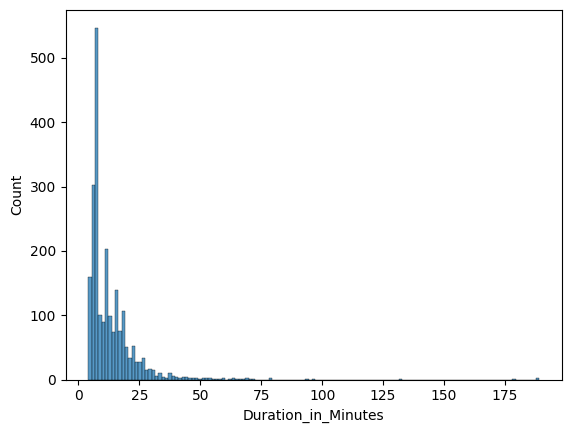

In [320]:
sns.histplot(df_fetch_requests["Duration_in_Minutes"][df_fetch_requests["Duration_in_Minutes"] < 200])

In [321]:
log_minutes = np.log10(df_fetch_requests.Duration_in_Minutes)

Text(0.5, 0, 'Log_10(Duration_in_Minutes)')

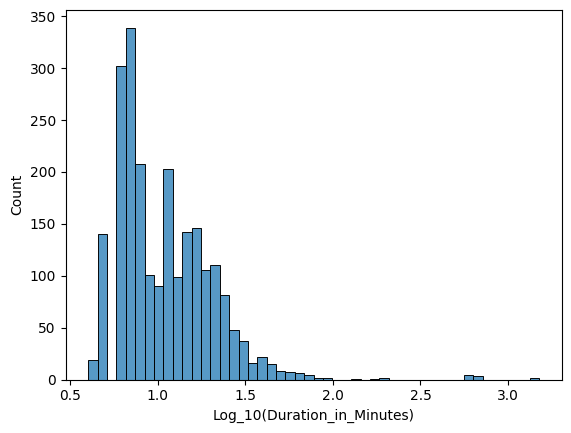

In [322]:
sns.histplot(log_minutes)
plt.xlabel("Log_10(Duration_in_Minutes)")

In [323]:
#df_fetch_requests["INSERT_DTTM"].to_datetime()
df_fetch_requests["INSERT_DATE"] = pd.to_datetime(df_fetch_requests["INSERT_DTTM"]).dt.date
df_fetch_requests["COMPLETE_DATE"] = pd.to_datetime(df_fetch_requests["COMPLETE_DTTM"]).dt.date

In [324]:
df_fetch_requests

,Line,item,item_type,FROM_LOCATION,TO_LOCATION,INSERT_DTTM,COMPLETE_DTTM,Duration_in_Minutes,INSERT_DATE,COMPLETE_DATE
0,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.01.04,RAW.HNDOFF.05,2024-10-02 19:58:53,2024-10-02 20:08:23,10.0,2024-10-02,2024-10-02
1,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.03.04,RAW.HNDOFF.05,2024-10-03 00:08:12,2024-10-03 00:26:06,18.0,2024-10-03,2024-10-03
2,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.03.04,RAW.HNDOFF.06,2024-10-03 00:08:19,2024-10-03 00:32:55,24.0,2024-10-03,2024-10-03
3,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.05.02,RAW.HNDOFF.05,2024-11-08 13:37:45,2024-11-08 13:42:07,5.0,2024-11-08,2024-11-08
4,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.14.04,RAW.HNDOFF.06,2025-01-02 22:40:26,2025-01-02 22:57:24,17.0,2025-01-02,2025-01-02
...,...,...,...,...,...,...,...,...,...,...
2261,MES2,SHV01SMV106DSM2S,SHRF,SR.S.40.01,RAW.HNDOFF.06,2025-02-07 17:20:25,2025-02-07 17:26:21,6.0,2025-02-07,2025-02-07
2262,MES2,SHV01SMV106DSM2S,SHRF,SR.N.12.02,RAW.HNDOFF.06,2024-12-09 19:19:16,2024-12-09 19:32:18,13.0,2024-12-09,2024-12-09
2263,MES2,SHV01SMV106DSM2S,SHRF,SR.S.27.03,RAW.HNDOFF.06,2025-02-18 17:40:07,2025-02-18 17:50:22,10.0,2025-02-18,2025-02-18
2264,MES2,SHV01SMV106DSM2S,SHRF,SR.S.37.01,RAW.HNDOFF.06,2025-02-07 14:42:29,2025-02-07 14:55:37,13.0,2025-02-07,2025-02-07


In [325]:
#df_produced = pd.read_csv("initial_files/csv_files/lou_total_cases_produced.csv")
#df_produced["Date"] = pd.to_datetime(df_produced["Date"], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
#df_produced.dtypes
#df_produced.head()

In [326]:
# Create the SQLAlchemy engine (FS DB)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={fs_params}")
# Try to connect and execute a simple query
with engine.connect() as connection:

    # Write SQL Query here
    query = text(
                    
"""
    SELECT DISTINCT
    ORG,CONCAT(ORG,RIGHT(LINE,1)) COLLATE DATABASE_DEFAULT AS Prod_Line, CONVERT(DATE, ACTUAL_START_TIME) AS Date, SUM(ACTUAL_QUANTITY) AS Total_Cases_Produced

    FROM history.LMS_Workbench
    WHERE ORG = 'MES'
    AND LINE IN ('ME1', 'ME2')
    AND DATEDIFF(DAY,ACTUAL_START_TIME, GETDATE()) <= 180

    GROUP BY ORG,CONCAT(ORG,RIGHT(LINE,1)) COLLATE DATABASE_DEFAULT, LINE, CONVERT(DATE, ACTUAL_START_TIME)
    ORDER BY Date
        
"""
                    )

    result = connection.execute(query)
    print(result)
    df_produced = pd.DataFrame(result.fetchall(), columns=result.keys())
    df_produced.Total_Cases_Produced = df_produced.Total_Cases_Produced.astype(int)

In [327]:
df_produced.shape

(225, 4)

In [328]:
# Create the SQLAlchemy engine (FS DB)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={fs_params}")
# Try to connect and execute a simple query
with engine.connect() as connection:

    # Write SQL Query here
    query = text(
                    
"""
    WITH CTE AS (
    SELECT DISTINCT ORG, TC_SHIPMENT_ID, SHIPPED_QTY, CONVERT(DATE, ACTUAL_SHIPPED_DTTM) AS SHIPPED_DATE
    FROM history.MA_ShipmentHistory
    WHERE ORG = 'MES'
    AND DATEDIFF(DAY,ACTUAL_SHIPPED_DTTM,GETDATE()) <= 180
    )
    ,
    CTE2 AS (
    SELECT ORG, SHIPPED_DATE, SUM(SHIPPED_QTY) AS Total_Cases_Shipped
    FROM CTE
    GROUP BY ORG, SHIPPED_DATE
    )

    SELECT DISTINCT
    ORG, SHIPPED_DATE, CAST(Total_Cases_Shipped AS int) AS Total_Cases_Shipped FROM CTE2
    ORDER BY SHIPPED_DATE

"""
                    )

    result = connection.execute(query)
    print(result)
    df_shipped = pd.DataFrame(result.fetchall(), columns=result.keys())

In [329]:
df_shipped.shape

(149, 3)

In [330]:
df_shipped.dtypes

ORG                    object
SHIPPED_DATE           object
Total_Cases_Shipped     int64
dtype: object

In [331]:
# df_shipped = pd.read_csv("initial_files/csv_files/lou_total_cases_shipped.csv")
# df_shipped["SHIPPED_DATE"] = pd.to_datetime(df_shipped["SHIPPED_DATE"], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
# df_shipped.dtypes

In [332]:
df_fetch_requests["INSERT_DATE"] = pd.to_datetime(df_fetch_requests["INSERT_DATE"])
df_fetch_requests["COMPLETE_DATE"] = pd.to_datetime(df_fetch_requests["COMPLETE_DATE"])
df_fetch_requests["INSERT_DTTM"] = pd.to_datetime(df_fetch_requests["INSERT_DTTM"])
df_fetch_requests["COMPLETE_DTTM"] = pd.to_datetime(df_fetch_requests["COMPLETE_DTTM"])
#df_fetch_requests.dtypes

In [333]:
df_produced["Date"] = pd.to_datetime(df_produced["Date"])
df_shipped["SHIPPED_DATE"] = pd.to_datetime(df_shipped["SHIPPED_DATE"])

In [334]:
df_fetch_requests = pd.merge(df_fetch_requests, df_produced, left_on='INSERT_DATE', right_on='Date', how='left')
df_fetch_requests

,Line,item,item_type,FROM_LOCATION,TO_LOCATION,INSERT_DTTM,COMPLETE_DTTM,Duration_in_Minutes,INSERT_DATE,COMPLETE_DATE,ORG,Prod_Line,Date,Total_Cases_Produced
0,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.01.04,RAW.HNDOFF.05,2024-10-02 19:58:53,2024-10-02 20:08:23,10.0,2024-10-02,2024-10-02,MES,MES1,2024-10-02,84800.0
1,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.01.04,RAW.HNDOFF.05,2024-10-02 19:58:53,2024-10-02 20:08:23,10.0,2024-10-02,2024-10-02,MES,MES2,2024-10-02,62616.0
2,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.03.04,RAW.HNDOFF.05,2024-10-03 00:08:12,2024-10-03 00:26:06,18.0,2024-10-03,2024-10-03,MES,MES1,2024-10-03,59579.0
3,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.03.04,RAW.HNDOFF.05,2024-10-03 00:08:12,2024-10-03 00:26:06,18.0,2024-10-03,2024-10-03,MES,MES2,2024-10-03,69134.0
4,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.03.04,RAW.HNDOFF.06,2024-10-03 00:08:19,2024-10-03 00:32:55,24.0,2024-10-03,2024-10-03,MES,MES1,2024-10-03,59579.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3426,MES2,SHV01SMV106DSM2S,SHRF,SR.N.12.02,RAW.HNDOFF.06,2024-12-09 19:19:16,2024-12-09 19:32:18,13.0,2024-12-09,2024-12-09,MES,MES2,2024-12-09,18898.0
3427,MES2,SHV01SMV106DSM2S,SHRF,SR.S.27.03,RAW.HNDOFF.06,2025-02-18 17:40:07,2025-02-18 17:50:22,10.0,2025-02-18,2025-02-18,MES,MES1,2025-02-18,19600.0
3428,MES2,SHV01SMV106DSM2S,SHRF,SR.S.27.03,RAW.HNDOFF.06,2025-02-18 17:40:07,2025-02-18 17:50:22,10.0,2025-02-18,2025-02-18,MES,MES2,2025-02-18,55238.0
3429,MES2,SHV01SMV106DSM2S,SHRF,SR.S.37.01,RAW.HNDOFF.06,2025-02-07 14:42:29,2025-02-07 14:55:37,13.0,2025-02-07,2025-02-07,MES,MES2,2025-02-07,17563.0


In [335]:
df_fetch_requests = pd.merge(df_fetch_requests, df_shipped, left_on='INSERT_DATE', right_on='SHIPPED_DATE', how='inner')
df_fetch_requests

,Line,item,item_type,FROM_LOCATION,TO_LOCATION,INSERT_DTTM,COMPLETE_DTTM,Duration_in_Minutes,INSERT_DATE,COMPLETE_DATE,ORG_x,Prod_Line,Date,Total_Cases_Produced,ORG_y,SHIPPED_DATE,Total_Cases_Shipped
0,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.05.02,RAW.HNDOFF.05,2024-11-08 13:37:45,2024-11-08 13:42:07,5.0,2024-11-08,2024-11-08,NaN,NaN,NaT,NaN,MES,2024-11-08,80688
1,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.14.04,RAW.HNDOFF.06,2025-01-02 22:40:26,2025-01-02 22:57:24,17.0,2025-01-02,2025-01-02,MES,MES1,2025-01-02,20268.0,MES,2025-01-02,112825
2,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.14.04,RAW.HNDOFF.06,2025-01-02 22:40:26,2025-01-02 22:57:24,17.0,2025-01-02,2025-01-02,MES,MES2,2025-01-02,44552.0,MES,2025-01-02,112825
3,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.08.04,RAW.HNDOFF.05,2024-11-09 17:59:55,2024-11-09 18:06:20,7.0,2024-11-09,2024-11-09,MES,MES1,2024-11-09,76421.0,MES,2024-11-09,81215
4,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.11.04,RAW.HNDOFF.05,2024-11-10 12:38:18,2024-11-10 12:43:33,5.0,2024-11-10,2024-11-10,MES,MES1,2024-11-10,135259.0,MES,2024-11-10,51908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,MES2,SHV01SMV106DSM2S,SHRF,SR.N.12.02,RAW.HNDOFF.06,2024-12-09 19:19:16,2024-12-09 19:32:18,13.0,2024-12-09,2024-12-09,MES,MES2,2024-12-09,18898.0,MES,2024-12-09,75349
2764,MES2,SHV01SMV106DSM2S,SHRF,SR.S.27.03,RAW.HNDOFF.06,2025-02-18 17:40:07,2025-02-18 17:50:22,10.0,2025-02-18,2025-02-18,MES,MES1,2025-02-18,19600.0,MES,2025-02-18,89344
2765,MES2,SHV01SMV106DSM2S,SHRF,SR.S.27.03,RAW.HNDOFF.06,2025-02-18 17:40:07,2025-02-18 17:50:22,10.0,2025-02-18,2025-02-18,MES,MES2,2025-02-18,55238.0,MES,2025-02-18,89344
2766,MES2,SHV01SMV106DSM2S,SHRF,SR.S.37.01,RAW.HNDOFF.06,2025-02-07 14:42:29,2025-02-07 14:55:37,13.0,2025-02-07,2025-02-07,MES,MES2,2025-02-07,17563.0,MES,2025-02-07,94149


In [336]:
df_fetch_requests = df_fetch_requests[["Line","item","item_type","FROM_LOCATION","TO_LOCATION","INSERT_DTTM","COMPLETE_DTTM","Duration_in_Minutes","INSERT_DATE","COMPLETE_DATE","Total_Cases_Produced","Total_Cases_Shipped"]]

In [337]:
df_fetch_requests.columns = df_fetch_requests.columns.str.lower().str.replace(' ', '_')

In [338]:
df_fetch_requests = df_fetch_requests.rename(columns={"total_cases_produced": "total_cases_produced_for_day","total_cases_shipped": "total_cases_shipped_for_day", "test":"line"})
df_fetch_requests

,line,item,item_type,from_location,to_location,insert_dttm,complete_dttm,duration_in_minutes,insert_date,complete_date,total_cases_produced_for_day,total_cases_shipped_for_day
0,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.05.02,RAW.HNDOFF.05,2024-11-08 13:37:45,2024-11-08 13:42:07,5.0,2024-11-08,2024-11-08,NaN,80688
1,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.14.04,RAW.HNDOFF.06,2025-01-02 22:40:26,2025-01-02 22:57:24,17.0,2025-01-02,2025-01-02,20268.0,112825
2,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.14.04,RAW.HNDOFF.06,2025-01-02 22:40:26,2025-01-02 22:57:24,17.0,2025-01-02,2025-01-02,44552.0,112825
3,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.08.04,RAW.HNDOFF.05,2024-11-09 17:59:55,2024-11-09 18:06:20,7.0,2024-11-09,2024-11-09,76421.0,81215
4,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.11.04,RAW.HNDOFF.05,2024-11-10 12:38:18,2024-11-10 12:43:33,5.0,2024-11-10,2024-11-10,135259.0,51908
...,...,...,...,...,...,...,...,...,...,...,...,...
2763,MES2,SHV01SMV106DSM2S,SHRF,SR.N.12.02,RAW.HNDOFF.06,2024-12-09 19:19:16,2024-12-09 19:32:18,13.0,2024-12-09,2024-12-09,18898.0,75349
2764,MES2,SHV01SMV106DSM2S,SHRF,SR.S.27.03,RAW.HNDOFF.06,2025-02-18 17:40:07,2025-02-18 17:50:22,10.0,2025-02-18,2025-02-18,19600.0,89344
2765,MES2,SHV01SMV106DSM2S,SHRF,SR.S.27.03,RAW.HNDOFF.06,2025-02-18 17:40:07,2025-02-18 17:50:22,10.0,2025-02-18,2025-02-18,55238.0,89344
2766,MES2,SHV01SMV106DSM2S,SHRF,SR.S.37.01,RAW.HNDOFF.06,2025-02-07 14:42:29,2025-02-07 14:55:37,13.0,2025-02-07,2025-02-07,17563.0,94149


In [339]:
df_fetch_requests["duration_in_minutes"] = df_fetch_requests["duration_in_minutes"].round(2)

In [340]:
df_fetch_requests

,line,item,item_type,from_location,to_location,insert_dttm,complete_dttm,duration_in_minutes,insert_date,complete_date,total_cases_produced_for_day,total_cases_shipped_for_day
0,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.05.02,RAW.HNDOFF.05,2024-11-08 13:37:45,2024-11-08 13:42:07,5.0,2024-11-08,2024-11-08,NaN,80688
1,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.14.04,RAW.HNDOFF.06,2025-01-02 22:40:26,2025-01-02 22:57:24,17.0,2025-01-02,2025-01-02,20268.0,112825
2,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.14.04,RAW.HNDOFF.06,2025-01-02 22:40:26,2025-01-02 22:57:24,17.0,2025-01-02,2025-01-02,44552.0,112825
3,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.08.04,RAW.HNDOFF.05,2024-11-09 17:59:55,2024-11-09 18:06:20,7.0,2024-11-09,2024-11-09,76421.0,81215
4,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.11.04,RAW.HNDOFF.05,2024-11-10 12:38:18,2024-11-10 12:43:33,5.0,2024-11-10,2024-11-10,135259.0,51908
...,...,...,...,...,...,...,...,...,...,...,...,...
2763,MES2,SHV01SMV106DSM2S,SHRF,SR.N.12.02,RAW.HNDOFF.06,2024-12-09 19:19:16,2024-12-09 19:32:18,13.0,2024-12-09,2024-12-09,18898.0,75349
2764,MES2,SHV01SMV106DSM2S,SHRF,SR.S.27.03,RAW.HNDOFF.06,2025-02-18 17:40:07,2025-02-18 17:50:22,10.0,2025-02-18,2025-02-18,19600.0,89344
2765,MES2,SHV01SMV106DSM2S,SHRF,SR.S.27.03,RAW.HNDOFF.06,2025-02-18 17:40:07,2025-02-18 17:50:22,10.0,2025-02-18,2025-02-18,55238.0,89344
2766,MES2,SHV01SMV106DSM2S,SHRF,SR.S.37.01,RAW.HNDOFF.06,2025-02-07 14:42:29,2025-02-07 14:55:37,13.0,2025-02-07,2025-02-07,17563.0,94149


In [341]:
features_list = list(df_fetch_requests.columns)
features_list

['line',
 'item',
 'item_type',
 'from_location',
 'to_location',
 'insert_dttm',
 'complete_dttm',
 'duration_in_minutes',
 'insert_date',
 'complete_date',
 'total_cases_produced_for_day',
 'total_cases_shipped_for_day']

In [342]:
for v in ['MES1', 'MES2']:
    feature = f"line_{v}"
    df_fetch_requests[feature] = (df_fetch_requests["line"] == v).astype(int)
    features_list.append(feature)

In [343]:
for v in ['SHRF', 'LABL']:
    feature = f"item_type_{v}"
    df_fetch_requests[feature] = (df_fetch_requests["item_type"] == v).astype(int)
    features_list.append(feature)

In [344]:
df_fetch_requests.from_location.value_counts()

from_location
SR.S.27.03    29
SR.S.38.05    27
SR.N.15.01    26
SR.S.37.05    26
SR.S.26.05    25
              ..
SR.N.26.01     1
SR.N.14.05     1
SR.S.28.02     1
SR.N.16.04     1
SR.S.24.02     1
Name: count, Length: 325, dtype: int64

In [345]:
df_fetch_requests["storage_location_type"] = df_fetch_requests["from_location"].str[0:4]

In [346]:
df_fetch_requests.head()

,line,item,item_type,from_location,to_location,insert_dttm,complete_dttm,duration_in_minutes,insert_date,complete_date,total_cases_produced_for_day,total_cases_shipped_for_day,line_MES1,line_MES2,item_type_SHRF,item_type_LABL,storage_location_type
0,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.05.02,RAW.HNDOFF.05,2024-11-08 13:37:45,2024-11-08 13:42:07,5.0,2024-11-08,2024-11-08,NaN,80688,0,1,1,0,SR.N
1,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.14.04,RAW.HNDOFF.06,2025-01-02 22:40:26,2025-01-02 22:57:24,17.0,2025-01-02,2025-01-02,20268.0,112825,0,1,1,0,SR.N
2,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.14.04,RAW.HNDOFF.06,2025-01-02 22:40:26,2025-01-02 22:57:24,17.0,2025-01-02,2025-01-02,44552.0,112825,0,1,1,0,SR.N
3,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.08.04,RAW.HNDOFF.05,2024-11-09 17:59:55,2024-11-09 18:06:20,7.0,2024-11-09,2024-11-09,76421.0,81215,0,1,1,0,SR.N
4,MES2,SHV01CLR17275CCNAK,SHRF,SR.N.11.04,RAW.HNDOFF.05,2024-11-10 12:38:18,2024-11-10 12:43:33,5.0,2024-11-10,2024-11-10,135259.0,51908,0,1,1,0,SR.N


In [347]:
# df_fetch_requests.total_cases_produced_for_day.isnull().value_counts()
# df_fetch_requests.total_cases_shipped_for_day.isnull().value_counts()
df_fetch_requests.total_cases_produced_for_day = df_fetch_requests.total_cases_produced_for_day.fillna(0)
df_fetch_requests.total_cases_shipped_for_day = df_fetch_requests.total_cases_shipped_for_day.fillna(0)

In [348]:
for v in ['SR.N', 'SR.S']:
    feature = f"storage_location_type_{v}"
    df_fetch_requests[feature] = (df_fetch_requests["storage_location_type"] == v).astype(int)
    features_list.append(feature)

In [349]:
df_fetch_requests.dtypes

line                                    object
item                                    object
item_type                               object
from_location                           object
to_location                             object
insert_dttm                     datetime64[ns]
complete_dttm                   datetime64[ns]
duration_in_minutes                    float64
insert_date                     datetime64[ns]
complete_date                   datetime64[ns]
total_cases_produced_for_day           float64
total_cases_shipped_for_day              int64
line_MES1                                int64
line_MES2                                int64
item_type_SHRF                           int64
item_type_LABL                           int64
storage_location_type                   object
storage_location_type_SR.N               int64
storage_location_type_SR.S               int64
dtype: object

In [350]:
numerical_matrix_df = df_fetch_requests.select_dtypes(include=['int64', 'float'])

In [351]:
numerical_matrix_df

,duration_in_minutes,total_cases_produced_for_day,total_cases_shipped_for_day,line_MES1,line_MES2,item_type_SHRF,item_type_LABL,storage_location_type_SR.N,storage_location_type_SR.S
0,5.0,0.0,80688,0,1,1,0,1,0
1,17.0,20268.0,112825,0,1,1,0,1,0
2,17.0,44552.0,112825,0,1,1,0,1,0
3,7.0,76421.0,81215,0,1,1,0,1,0
4,5.0,135259.0,51908,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...
2763,13.0,18898.0,75349,0,1,1,0,1,0
2764,10.0,19600.0,89344,0,1,1,0,0,1
2765,10.0,55238.0,89344,0,1,1,0,0,1
2766,13.0,17563.0,94149,0,1,1,0,0,1


In [352]:
# y_train_orig = df_train.duration_in_minutes.values
# y_val_orig = df_val.duration_in_minutes.values
# y_test_orig = df_test.duration_in_minutes.values

# y_train = np.log10(df_train.duration_in_minutes.values)
# y_val = np.log10(df_val.duration_in_minutes.values)
# y_test = np.log10(df_test.duration_in_minutes.values)

In [353]:
# Start with your original DataFrame (before the numerical conversion)
df_fetch_requests_enriched = df_fetch_requests.copy()

# 1. Handle Rare Locations
location_counts = df_fetch_requests_enriched['from_location'].value_counts()
rare_locations = location_counts[location_counts < 10].index
df_fetch_requests_enriched['location_grouped'] = df_fetch_requests_enriched['from_location'].apply(
    lambda x: 'RARE_LOCATION' if x in rare_locations else x
)

# 2. Add Location Statistics
location_avg = df_fetch_requests_enriched.groupby('location_grouped')['duration_in_minutes'].mean().to_dict()
location_median = df_fetch_requests_enriched.groupby('location_grouped')['duration_in_minutes'].median().to_dict()
location_std = df_fetch_requests_enriched.groupby('location_grouped')['duration_in_minutes'].std().fillna(0).to_dict()

df_fetch_requests_enriched['location_avg_time'] = df_fetch_requests_enriched['location_grouped'].map(location_avg)
df_fetch_requests_enriched['location_median_time'] = df_fetch_requests_enriched['location_grouped'].map(location_median)
df_fetch_requests_enriched['location_std_time'] = df_fetch_requests_enriched['location_grouped'].map(location_std)

# 3. Add Cross Features
df_fetch_requests_enriched['sr.n_with_shrf'] = ((df_fetch_requests_enriched['storage_location_type'] == 'SR.N') & 
                                           (df_fetch_requests_enriched['item_type'] == 'SHRF')).astype(int)
df_fetch_requests_enriched['sr.s_with_labl'] = ((df_fetch_requests_enriched['storage_location_type'] == 'SR.S') & 
                                           (df_fetch_requests_enriched['item_type'] == 'LABL')).astype(int)

# Time-based features from insert_dttm
df_fetch_requests_enriched['hour_of_day'] = df_fetch_requests_enriched['insert_dttm'].dt.hour
df_fetch_requests_enriched['day_of_week'] = df_fetch_requests_enriched['insert_dttm'].dt.dayofweek  # 0=Monday, 6=Sunday

# Create one-hot encoding for hour of day and day of week
for hour in range(24):
    df_fetch_requests_enriched[f'hour_{hour}'] = (df_fetch_requests_enriched['hour_of_day'] == hour).astype(int)

for day in range(7):
    df_fetch_requests_enriched[f'day_{day}'] = (df_fetch_requests_enriched['day_of_week'] == day).astype(int)

# Add features for business hours vs. off-hours
df_fetch_requests_enriched['business_hours'] = ((df_fetch_requests_enriched['hour_of_day'] >= 8) & 
                                           (df_fetch_requests_enriched['hour_of_day'] < 17) &
                                           (df_fetch_requests_enriched['day_of_week'] < 5)).astype(int)

df_fetch_requests_enriched['night_shift'] = ((df_fetch_requests_enriched['hour_of_day'] >= 19) | 
                                        (df_fetch_requests_enriched['hour_of_day'] < 7)).astype(int)

df_fetch_requests_enriched['weekend'] = (df_fetch_requests_enriched['day_of_week'] >= 5).astype(int)

# Calculate cases produced/shipped ratios
# Add a small value to avoid division by zero
epsilon = 1e-10
df_fetch_requests_enriched['cases_ratio'] = df_fetch_requests_enriched['total_cases_produced_for_day'] / (df_fetch_requests_enriched['total_cases_shipped_for_day'] + epsilon)

# Cap extreme ratios to prevent outliers
df_fetch_requests_enriched['cases_ratio'] = df_fetch_requests_enriched['cases_ratio'].clip(0, 10)

# Hour + item_type interaction features
df_fetch_requests_enriched['morning_shrf'] = ((df_fetch_requests_enriched['hour_of_day'] < 12) & 
                                         (df_fetch_requests_enriched['item_type'] == 'SHRF')).astype(int)

df_fetch_requests_enriched['evening_labl'] = ((df_fetch_requests_enriched['hour_of_day'] >= 19) & 
                                         (df_fetch_requests_enriched['item_type'] == 'LABL')).astype(int)

# Update numerical_columns to include new features
numerical_columns = [
    'duration_in_minutes', 'total_cases_produced_for_day', 'total_cases_shipped_for_day',
    'line_MES1', 'line_MES2',
    'item_type_SHRF', 'item_type_LABL', 'storage_location_type_SR.N', 'storage_location_type_SR.S',
    'location_avg_time', 'location_median_time', 'location_std_time',
    'sr.n_with_shrf', 'sr.s_with_labl',
    'cases_ratio',
    'business_hours', 'night_shift', 'weekend',
    'morning_shrf', 'evening_labl'
]

# Add hour and day dummy variables (dropping one from each to avoid multicollinearity)
for hour in range(1, 24):  # Skip hour_0 as the reference category
    numerical_columns.append(f'hour_{hour}')

for day in range(1, 7):  # Skip day_0 (Monday) as the reference category
    numerical_columns.append(f'day_{day}')

# Create the numerical matrix with our enhanced features
df_numerical = df_fetch_requests_enriched[numerical_columns]

# Then continue with your existing train/val/test split logic
np.random.seed(2)
n = len(df_numerical)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df_numerical.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [354]:
y_train_orig = df_train.duration_in_minutes.values
y_val_orig = df_val.duration_in_minutes.values
y_test_orig = df_test.duration_in_minutes.values

y_train = np.log10(df_train.duration_in_minutes.values)
y_val = np.log10(df_val.duration_in_minutes.values)
y_test = np.log10(df_test.duration_in_minutes.values)

In [ ]:
def prepare_X(df):
    df = df.copy()
    
    # Remove target variable if it exists
    if 'duration_in_minutes' in df.columns:
        df = df.drop('duration_in_minutes', axis=1)
    
    # Drop one category from each set of dummy variables to avoid multicollinearity
    columns_to_drop = ['line_MES2', 'item_type_LABL', 'storage_location_type_SR.S']
    df = df.drop([x for x in columns_to_drop if x in df.columns], axis=1)
    
    feature_names = list(df.columns)
    X = df.values
    return X, feature_names

In [356]:
X_train = prepare_X(df_train)
X_train

(array([[7.3195e+04, 5.0376e+04, 1.0000e+00, ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [2.5240e+03, 9.2709e+04, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.5240e+03, 9.2709e+04, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [6.1617e+04, 9.8954e+04, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 7.8252e+04, 1.0000e+00, ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [9.0854e+04, 9.3535e+04, 1.0000e+00, ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00]]),
 ['total_cases_produced_for_day',
  'total_cases_shipped_for_day',
  'line_MES1',
  'line_MES2',
  'item_type_SHRF',
  'storage_location_type_SR.N',
  'location_avg_time',
  'location_median_time',
  'location_std_time',
  'sr.n_with_shrf',
  'sr.s_with_labl',
  'cases_ratio',
  'business_hours',
  'night_shift',
  'weekend',
  'morning_shrf',
  'evening_labl',
  'hour_1',
  'hour_2',
  'hour_3',
  'hour_4

Best parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Tuned RF Training RMSE: 0.1722
Tuned RF Validation RMSE: 0.2316
1. total_cases_produced_for_day: 0.0642
2. total_cases_shipped_for_day: 0.1194
3. line_MES1: 0.0140
4. line_MES2: 0.0125
5. item_type_SHRF: 0.0186
6. storage_location_type_SR.N: 0.0101
7. location_avg_time: 0.2039
8. location_median_time: 0.0589
9. location_std_time: 0.0787
10. sr.n_with_shrf: 0.0081
11. sr.s_with_labl: 0.0055
12. cases_ratio: 0.0597
13. business_hours: 0.0120
14. night_shift: 0.0112
15. weekend: 0.0053
16. morning_shrf: 0.0104
17. evening_labl: 0.0008
18. hour_1: 0.0103
19. hour_2: 0.0057
20. hour_3: 0.0030
Feature ranking:
1. location_avg_time (0.2039)
2. total_cases_shipped_for_day (0.1194)
3. location_std_time (0.0787)
4. total_cases_produced_for_day (0.0642)
5. cases_ratio (0.0597)
6. location_median_time (0.0589)
7. hour_4 (0.0336)
8. day_1 (0.0311)
9. hour_6 (0.0210)
10. day_3 (0.0187)
11. item_type

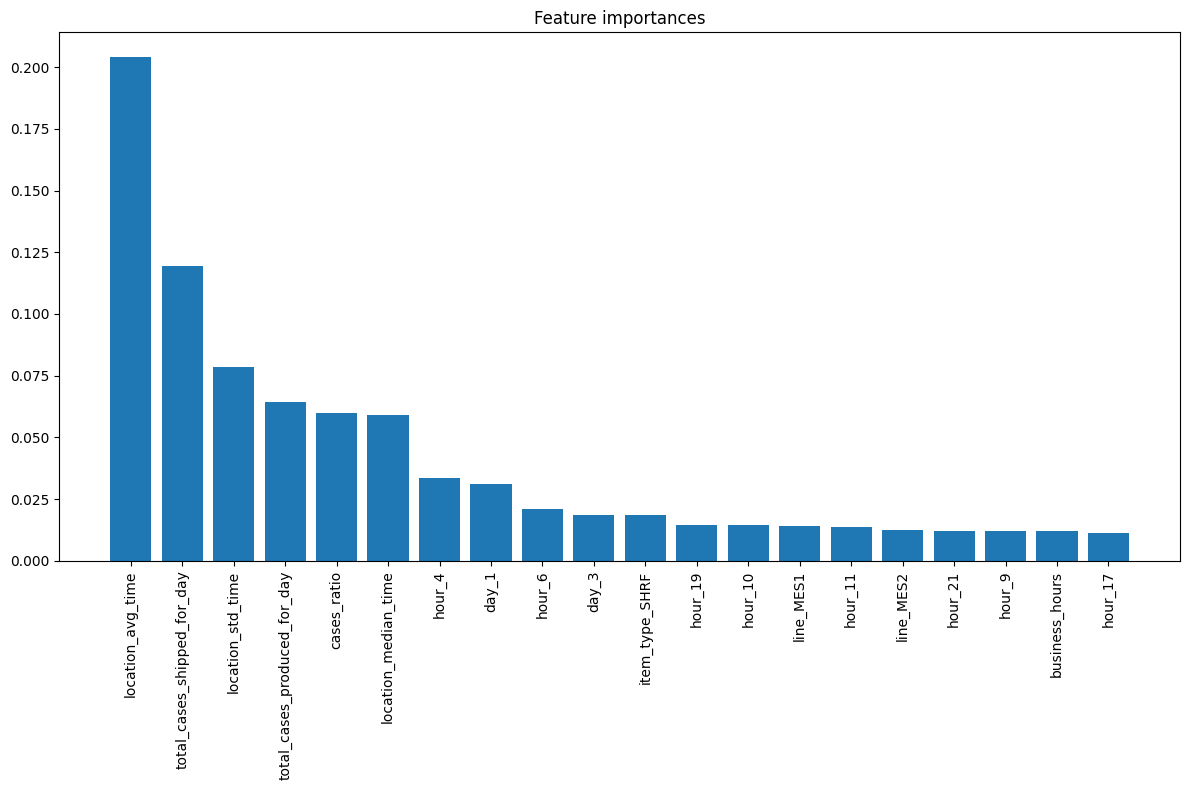

In [357]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare data
X_train, feature_names = prepare_X(df_train)
X_val, _ = prepare_X(df_val)

# 1. Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                  n_iter=10, cv=3, scoring='neg_mean_squared_error',
                                  random_state=42)
random_search.fit(X_train, y_train)

# Get the best model
best_rf = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")

# 2. Make predictions with the tuned model
y_train_pred_rf = best_rf.predict(X_train)
y_val_pred_rf = best_rf.predict(X_val)

# Calculate RMSE
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
val_rmse_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))

print(f"Tuned RF Training RMSE: {train_rmse_rf:.4f}")
print(f"Tuned RF Validation RMSE: {val_rmse_rf:.4f}")

# 3. Feature importance analysis
importances = best_rf.feature_importances_
# Get feature names - adjust this depending on how you access column names
#feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"feature_{i}" for i in range(X_train.shape[1])]
indices = np.argsort(importances)[::-1]

# Print direct feature importances
for i, (name, importance) in enumerate(zip(feature_names, importances)):
    if i < 20:  # Just print the first 20
        print(f"{i+1}. {name}: {importance:.4f}")

# Print the feature ranking
print("Feature ranking:")
for f in range(min(20, X_train.shape[1])):
    if f < len(indices):
        feature_idx = indices[f]
        if feature_idx < len(feature_names):
            feature_name = feature_names[feature_idx]
            importance = importances[feature_idx]
            print(f"{f+1}. {feature_name} ({importance:.4f})")

# 4. Plot feature importances (optional)
plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(min(20, X_train.shape[1])), 
        [importances[i] for i in indices[:20]],
        align="center")
plt.xticks(range(min(20, X_train.shape[1])), 
           [feature_names[i] for i in indices[:20]], 
           rotation=90)
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Log10(duration_in_minutes)')

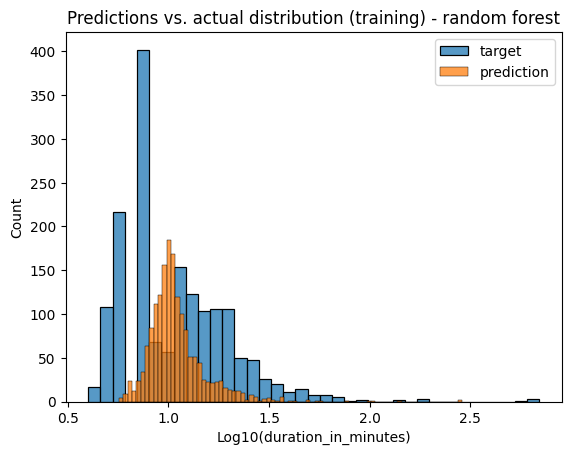

In [358]:
sns.histplot(y_train, label='target')
sns.histplot(y_train_pred_rf, label='prediction')

plt.legend()
plt.title('Predictions vs. actual distribution (training) - random forest')
plt.xlabel('Log10(duration_in_minutes)')

Text(0.5, 0, 'Log10(duration_in_minutes)')

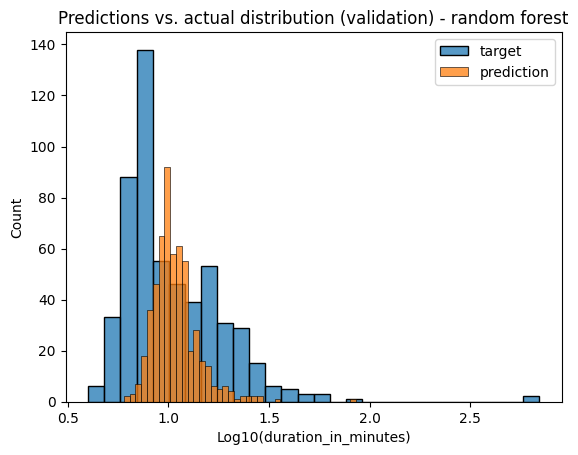

In [359]:
sns.histplot(y_val, label='target')
sns.histplot(y_val_pred_rf, label='prediction')

plt.legend()
plt.title('Predictions vs. actual distribution (validation) - random forest')
plt.xlabel('Log10(duration_in_minutes)')

In [360]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare data
X_train, feature_names = prepare_X(df_train)
X_val, _ = prepare_X(df_val)
X_test, _ = prepare_X(df_test)  # If you have test data

# Create model with the best parameters you already found
best_params = {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1}
rf_model = RandomForestRegressor(**best_params, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"RF Training RMSE: {train_rmse:.4f}")
print(f"RF Validation RMSE: {val_rmse:.4f}")

# Feature importance analysis
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(min(10, X_train.shape[1])):
    feature_idx = indices[f]
    feature_name = feature_names[feature_idx]
    importance = importances[feature_idx]
    print(f"{f+1}. {feature_name} ({importance:.4f})")

RF Training RMSE: 0.1059
RF Validation RMSE: 0.2367
Feature ranking:
1. location_avg_time (0.1475)
2. total_cases_shipped_for_day (0.1143)
3. total_cases_produced_for_day (0.0774)
4. cases_ratio (0.0743)
5. location_std_time (0.0723)
6. location_median_time (0.0521)
7. hour_4 (0.0269)
8. day_1 (0.0245)
9. item_type_SHRF (0.0196)
10. hour_6 (0.0183)


In [361]:
def predict_retrieval_times_monte_carlo(
    item_type, 
    production_line, 
    cases_produced, 
    cases_shipped,
    day_of_week,
    hour_of_day,
    n_simulations=1000):
    
    # Create a base record with the known features
    base_record = {
        'total_cases_produced_for_day': cases_produced,
        'total_cases_shipped_for_day': cases_shipped,
        'cases_ratio': cases_produced / (cases_shipped + 1e-10),
        'line_MES1': 1 if production_line == 'MES1' else 0,
        'item_type_SHRF': 1 if item_type == 'SHRF' else 0,
        'storage_location_type_SR.N': 1,  # Default to SR.N
        'business_hours': 1 if (hour_of_day >= 8 and hour_of_day < 17 and day_of_week < 5) else 0,
        'night_shift': 1 if (hour_of_day >= 22 or hour_of_day < 6) else 0,
        'weekend': 1 if day_of_week >= 5 else 0,
        'morning_shrf': 1 if (hour_of_day < 12 and item_type == 'SHRF') else 0,
        'evening_labl': 1 if (hour_of_day >= 17 and item_type == 'LABL') else 0,
        'sr.n_with_shrf': 1 if item_type == 'SHRF' else 0,
        'sr.s_with_labl': 0
    }
    
    # Add hour and day dummy variables
    for h in range(1, 24):
        base_record[f'hour_{h}'] = 1 if hour_of_day == h else 0
    
    for d in range(1, 7):
        base_record[f'day_{d}'] = 1 if day_of_week == d else 0
    
    # Filter for relevant records in df_numerical
    filter_mask = (
        (df_numerical['item_type_SHRF'] == base_record['item_type_SHRF']) &
        (df_numerical[f'line_{production_line}'] == 1)
    )
    
    matching_records = df_numerical[filter_mask]
    print(f"Found {len(matching_records)} matching records")
    
    if len(matching_records) > 0:
        # Sample location statistics from matching records
        predictions = []
        for _ in range(n_simulations):
            random_idx = np.random.randint(0, len(matching_records))
            selected_record = matching_records.iloc[random_idx]
            
            # Copy the base record and add location statistics
            simulation_record = base_record.copy()
            simulation_record['location_avg_time'] = selected_record['location_avg_time']
            simulation_record['location_median_time'] = selected_record['location_median_time']
            simulation_record['location_std_time'] = selected_record['location_std_time']
            
            # Ensure all required features are present
            simulation_df = pd.DataFrame([simulation_record])
            
            # Make sure all features are in the right order
            for feature in feature_names:
                if feature not in simulation_df.columns:
                    simulation_df[feature] = 0
            
            simulation_df = simulation_df[feature_names]
            
            # Make prediction and convert from log10 back to minutes
            log_prediction = rf_model.predict(simulation_df)[0]
            prediction_minutes = 10**log_prediction
            predictions.append(prediction_minutes)
        
        # Calculate statistics
        predictions = np.array(predictions)
        result = {
            'min': predictions.min(),
            '25th_percentile': np.percentile(predictions, 25),
            'median': np.median(predictions),
            'mean': predictions.mean(),
            '75th_percentile': np.percentile(predictions, 75),
            'max': predictions.max(),
            'std_dev': predictions.std(),
            'raw_predictions': predictions
        }
        return result
    else:
        return {"error": "No matching records found for this combination"}

Found 499 matching records
Predicted retrieval time (minutes):
Minimum: 7.62
25th percentile: 10.39
Median: 10.55
Mean: 10.64
75th percentile: 10.55
Maximum: 16.15
Standard deviation: 1.56


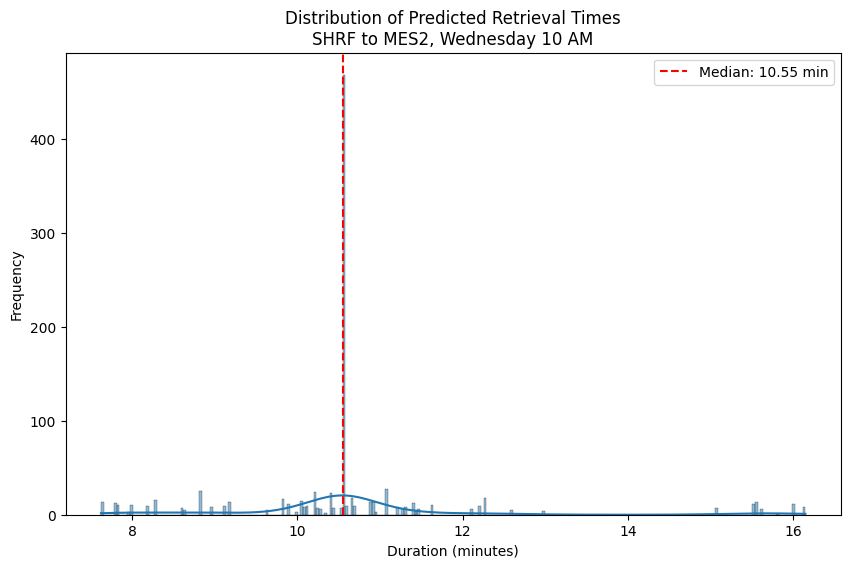

In [362]:
# Example usage
result = predict_retrieval_times_monte_carlo(
    item_type='SHRF',
    production_line='MES2',
    cases_produced=85000,
    cases_shipped=170000,
    day_of_week=2,  # Wednesday
    hour_of_day=10,  # 10 AM
    n_simulations=1000
)

# Print results
print(f"Predicted retrieval time (minutes):")
print(f"Minimum: {result['min']:.2f}")
print(f"25th percentile: {result['25th_percentile']:.2f}")
print(f"Median: {result['median']:.2f}")
print(f"Mean: {result['mean']:.2f}")
print(f"75th percentile: {result['75th_percentile']:.2f}")
print(f"Maximum: {result['max']:.2f}")
print(f"Standard deviation: {result['std_dev']:.2f}")

# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.histplot(result['raw_predictions'], kde=True)
plt.title(f"Distribution of Predicted Retrieval Times\nSHRF to MES2, Wednesday 10 AM")
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")
plt.axvline(result['median'], color='red', linestyle='--', label=f"Median: {result['median']:.2f} min")
plt.legend()
plt.show()

In [363]:
import warnings
# Only filter sklearn validation warnings about feature names
warnings.filterwarnings("ignore", message="X has feature names, but RandomForestRegressor was fitted without feature names")

# Or filter warnings from a specific module
warnings.filterwarnings("ignore", module="sklearn.utils.validation")

  0%|          | 0/16 [00:00<?, ?it/s]

Found 1330 matching records
Found 1330 matching records
Found 1330 matching records
Found 1330 matching records
Found 416 matching records
Found 416 matching records
Found 416 matching records
Found 416 matching records
Found 499 matching records
Found 499 matching records
Found 499 matching records
Found 499 matching records
Found 523 matching records
Found 523 matching records
Found 523 matching records
Found 523 matching records
Retrieval Risk Forecast:

Low Risk Retrievals:
Line Material  Time  Median (min)  Risk >45min (%)
MES1     SHRF 09:00          11.8              0.0
MES1     SHRF 13:00          14.5              0.0
MES1     SHRF 17:00          12.3              0.0
MES1     SHRF 21:00          12.8              0.0
MES1     LABL 09:00          13.2              0.0
MES1     LABL 13:00          14.3              0.0
MES1     LABL 17:00          12.8              0.0
MES1     LABL 21:00          13.5              0.0
MES2     SHRF 09:00          10.0              0.0
MES2   

C:\Users\sdcrunner47\AppData\Local\Temp\14\ipykernel_8220\1801872908.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  risk_plot.show()


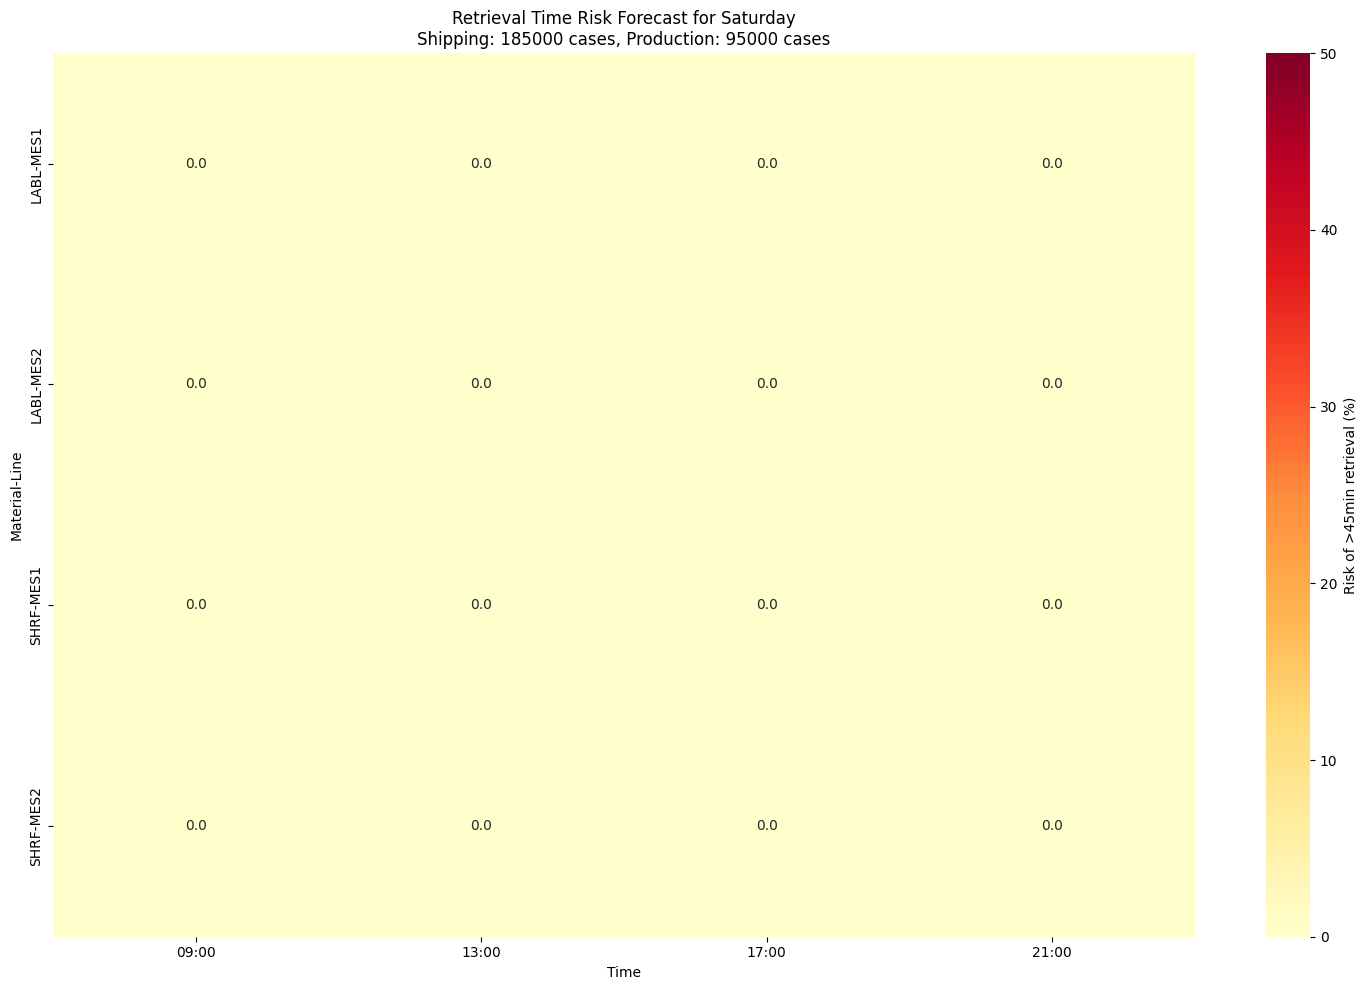

In [364]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm.notebook import tqdm

def forecast_retrieval_risks(day_of_week, shipping_forecast, production_forecast):
    """
    Generate a daily retrieval risk forecast dashboard
    
    Parameters:
    -----------
    day_of_week: int
        Day of week (0=Monday, 1=Tuesday, etc.)
    shipping_forecast: float
        Forecasted cases to be shipped
    production_forecast: float
        Forecasted cases to be produced
    """
    
    # Production lines and materials to check
    lines = ['MES1', 'MES2']
    materials = ['SHRF', 'LABL']
    
    # Time periods to check
    hours = [9, 13, 17, 21]  # 9AM, 1PM, 5PM, 9PM
    
    # Create a results table
    results = []
    total_combinations = len(lines) * len(materials) * len(hours)
    with tqdm(total=total_combinations) as pbar:
        for line in lines:
            for material in materials:
                for hour in hours:
                    # Run Monte Carlo simulation
                    sim_result = predict_retrieval_times_monte_carlo(
                        item_type=material,
                        production_line=line,
                        cases_produced=production_forecast,
                        cases_shipped=shipping_forecast,
                        day_of_week=day_of_week,
                        hour_of_day=hour,
                        n_simulations=200
                    )
                    
                    # Calculate risk metrics
                    if 'raw_predictions' in sim_result:
                        predictions = sim_result['raw_predictions']
                        risk_30min = (predictions > 30).mean() * 100  # % chance > 30 mins
                        risk_45min = (predictions > 45).mean() * 100  # % chance > 45 mins
                        median_time = sim_result['median']
                        max_time = sim_result['max']
                        
                        results.append({
                            'Line': line,
                            'Material': material,
                            'Time': f"{hour:02d}:00",
                            'Median (min)': round(median_time, 1),
                            'Max (min)': round(max_time, 1),
                            'Risk >30min (%)': round(risk_30min, 1),
                            'Risk >45min (%)': round(risk_45min, 1),
                            'Risk Level': 'High' if risk_45min > 20 else 'Medium' if risk_45min > 5 else 'Low'
                        })

                        # Update progress bar
                        pbar.update(1)
    
    # Convert to dataframe
    risk_df = pd.DataFrame(results)
    
    # Create a heatmap of risk levels
    plt.figure(figsize=(15, 10))
    
    # Define a pivot table for the heatmap
    heatmap_data = risk_df.pivot_table(
        index=['Material', 'Line'],
        columns='Time',
        values='Risk >45min (%)',
        aggfunc='mean'
    )
    
    # Plot the heatmap
    ax = sns.heatmap(heatmap_data, annot=True, cmap="YlOrRd", fmt=".1f", 
                    vmin=0, vmax=50, cbar_kws={'label': 'Risk of >45min retrieval (%)'})
    
    # Day name for title
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_name = days[day_of_week]
    
    plt.title(f"Retrieval Time Risk Forecast for {day_name}\nShipping: {shipping_forecast} cases, Production: {production_forecast} cases")
    plt.tight_layout()
    
    # Also return the tabular data
    return risk_df, plt.gcf()

# Example usage
tomorrow = datetime.now() + timedelta(days=1)
tomorrow_dow = tomorrow.weekday()  # 0=Monday, 1=Tuesday, etc.

# Sample forecast for tomorrow
shipping_forecast = 185000
production_forecast = 95000

# Generate the risk dashboard
risk_table, risk_plot = forecast_retrieval_risks(
    day_of_week=tomorrow_dow,
    shipping_forecast=shipping_forecast,
    production_forecast=production_forecast
)

# Display the tabular data, sorted by risk level
print("Retrieval Risk Forecast:")
for risk_level in ['High', 'Medium', 'Low']:
    level_risks = risk_table[risk_table['Risk Level'] == risk_level].sort_values(by='Risk >45min (%)', ascending=False)
    if len(level_risks) > 0:
        print(f"\n{risk_level} Risk Retrievals:")
        print(level_risks[['Line', 'Material', 'Time', 'Median (min)', 'Risk >45min (%)']].to_string(index=False))

# Display the plot
risk_plot.show()